In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
import plotly.express as px
import plotly.offline as pyo
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ratings = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/ratings_small.csv')
movies = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/movies_small.csv')
credits = pd.read_csv('/content/drive/My Drive/Project4_Trần Đức Long_124211/DL_Movies/credits_small.csv')

In [5]:
# Merging the credits and movies datasets
merged = pd.merge(movies, credits, left_on='id', right_on='movie_id')

# Creating a dictionary containing movie IDs and their titles from the merged dataset
movie_id_to_title = dict(zip(merged['id'], merged['title_x']))

In [6]:
# Restricting the IDs in the ratings file to those found in the merged dataset
matched_ratings = ratings[ratings['movieId'].isin(merged['id'])].copy()

# Extracting unique user and movie IDs
user_ids = matched_ratings['userId'].unique().tolist()
movie_ids = matched_ratings['movieId'].unique().tolist()

# Indexing the user and movie IDs
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

# Mapping user and movie IDs to their respective indices
matched_ratings['userId'] = matched_ratings['userId'].map(user_id_to_index)
matched_ratings['movieId'] = matched_ratings['movieId'].map(movie_id_to_index)

<ipython-input-7-b89fd6015654>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




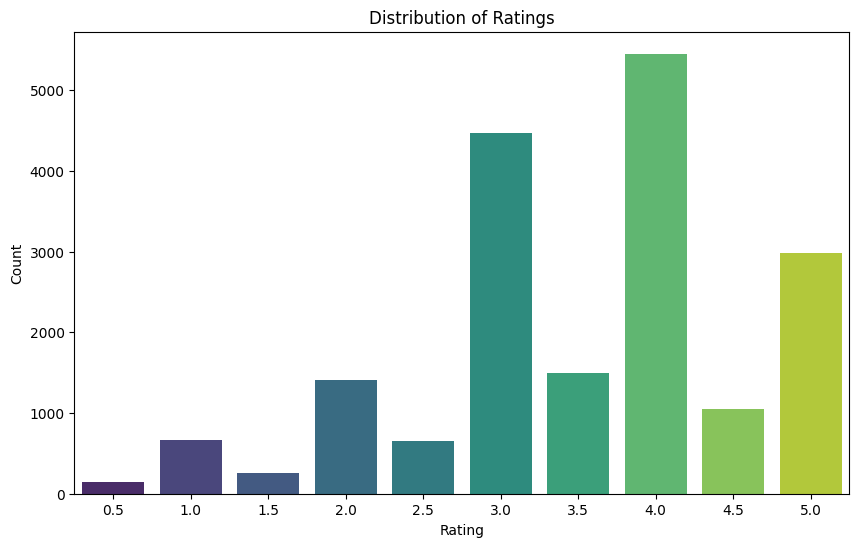

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=matched_ratings, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

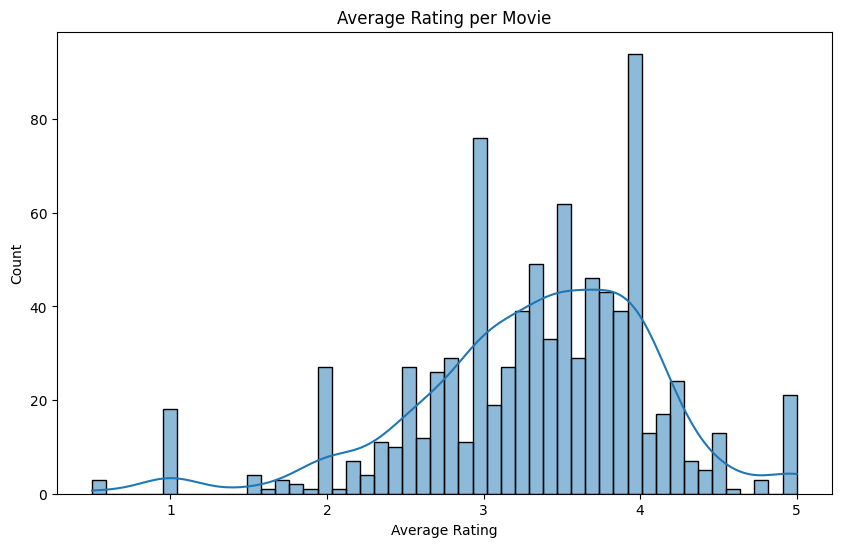

In [8]:
average_rating_per_movie = matched_ratings.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(average_rating_per_movie, bins=50, kde=True)
plt.title('Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

In [9]:
train, test = train_test_split(matched_ratings, test_size=0.2, random_state=42)

In [10]:
class RatingsDataset(torch.utils.data.Dataset):
    def __init__(self, ratings):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = self.ratings.iloc[idx, 0]
        movie = self.ratings.iloc[idx, 1]
        rating = self.ratings.iloc[idx, 2]
        return torch.tensor(user), torch.tensor(movie), torch.tensor(rating, dtype=torch.float32)

train_dataset = RatingsDataset(train)
test_dataset = RatingsDataset(test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=100):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 100

model = RecommenderNet(num_users, num_movies, embedding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for user, movie, rating in train_loader:
        optimizer.zero_grad()
        output = model(user, movie)
        loss = criterion(output, rating.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

# Save Model
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 1/10, Training Loss: 1.5810
Epoch 2/10, Training Loss: 0.8246
Epoch 3/10, Training Loss: 0.7098
Epoch 4/10, Training Loss: 0.6531
Epoch 5/10, Training Loss: 0.6115
Epoch 6/10, Training Loss: 0.5551
Epoch 7/10, Training Loss: 0.5271
Epoch 8/10, Training Loss: 0.4778
Epoch 9/10, Training Loss: 0.4421
Epoch 10/10, Training Loss: 0.4040


In [13]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

<ipython-input-13-56204ef9ea47>:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



RecommenderNet(
  (user_embedding): Embedding(670, 100)
  (movie_embedding): Embedding(857, 100)
  (fc1): Linear(in_features=200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# Recommend Function
def recommend_movies(user_id, num_recommendations=10):
    user_idx = user_id_to_index[user_id]
    user_tensor = torch.tensor([user_idx] * num_movies)
    movie_tensor = torch.tensor(np.arange(num_movies))

    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, movie_tensor).numpy().flatten()

    top_movie_indices = scores.argsort()[-num_recommendations:][::-1]
    recommended_movie_titles = [movie_id_to_title.get(movie_ids[i], "Unknown") for i in top_movie_indices]

    return recommended_movie_titles

# example recommend
user_id = 10
recommended_movies = recommend_movies(user_id)
print("Önerilen Filmler:", recommended_movies)

Önerilen Filmler: ['Get Shorty', 'The Celebration', 'Solaris', '1408', 'Runaway Bride', 'Terminator 3: Rise of the Machines', 'The Legend of Suriyothai', 'Love in the Time of Cholera', 'Stranger Than Fiction', 'Amélie']


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Tahminlerin yapılması
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for user, movie, rating in test_loader:
        output = model(user, movie)
        predictions.extend(output.numpy().flatten())
        actuals.extend(rating.numpy().flatten())

# RMSE ve MAE hesaplanması
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 0.9625630974769592
MAE: 0.7580012679100037


In [16]:
def precision_at_k(predictions, ground_truth, k):
    top_k_predictions = predictions.argsort()[-k:][::-1]
    relevant_items = ground_truth.argsort()[-k:][::-1]
    intersection = np.intersect1d(top_k_predictions, relevant_items)
    return len(intersection) / k

def recall_at_k(predictions, ground_truth, k):
    top_k_predictions = predictions.argsort()[-k:][::-1]
    relevant_items = ground_truth.argsort()[-k:][::-1]
    intersection = np.intersect1d(top_k_predictions, relevant_items)
    return len(intersection) / len(relevant_items)

In [17]:
k = 10
precision_scores = []
recall_scores = []

model.eval()
with torch.no_grad():
    for user, movie, rating in test_loader:
        output = model(user, movie).numpy().flatten()
        precision = precision_at_k(output, rating.numpy().flatten(), k)
        recall = recall_at_k(output, rating.numpy().flatten(), k)
        precision_scores.append(precision)
        recall_scores.append(recall)

average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print(f'Precision@{k}: {average_precision}')
print(f'Recall@{k}: {average_recall}')

Precision@10: 0.3067796610169491
Recall@10: 0.31864406779661014


In [19]:
import numpy as np
import torch

def recommend_movies_for_user(user_id, num_recommendations=10):
    """
    Hàm gợi ý phim cho một người dùng cụ thể.

    Args:
        user_id: ID của người dùng.
        num_recommendations: Số lượng phim được gợi ý.

    Returns:
        Một danh sách các tựa phim được gợi ý.
    """

    if user_id not in user_id_to_index:
        print(f"Người dùng có ID {user_id} không tồn tại trong tập dữ liệu.")
        return []

    user_idx = user_id_to_index[user_id]
    user_tensor = torch.tensor([user_idx] * num_movies)
    movie_tensor = torch.tensor(np.arange(num_movies))

    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, movie_tensor).numpy().flatten()

    top_movie_indices = scores.argsort()[-num_recommendations:][::-1]
    recommended_movie_titles = [movie_id_to_title.get(movie_ids[i], "Unknown") for i in top_movie_indices]

    return recommended_movie_titles

# Ví dụ sử dụng hàm gợi ý phim
user_id_to_recommend = 1  # Thay đổi ID người dùng ở đây
recommendations = recommend_movies_for_user(user_id_to_recommend)
print(f"Các phim được gợi ý cho người dùng {user_id_to_recommend}:")
for movie in recommendations:
    print(f"- {movie}")


Các phim được gợi ý cho người dùng 1:
- Impostor
- Apocalypse Now
- Notes on a Scandal
- Shall We Dance?
- Sicko
- Beverly Hills Cop III
- The Ladykillers
- The Karate Kid
- Flags of Our Fathers
- Elizabeth
